Package Installation

In [1]:
!pip install numpy
!pip install opencv-python
!pip install matplotlib

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from scipy.sparse import linalg as sla
from scipy import sparse

print("numpy version : ",np.__version__)
print("opencv version : ",cv2.__version__)

numpy version :  1.20.3
opencv version :  4.5.5


Preprocessing
1. Image Read & Subtract ambient image from other images

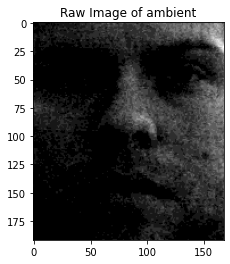

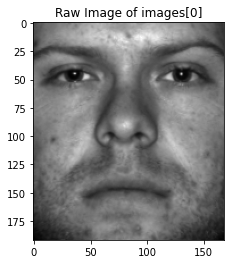

In [3]:
def load_images_from_folder(folder):
    info_list = [file for file in os.listdir(folder) if file.endswith('.info')]
    dataset = []
    for info in info_list:
        ambient = []
        images = []
        azimuth = []
        elevation = []
        with open(folder + info) as f:
            for line in f:
                line = line.strip('\n')
                img = cv2.imread(folder + line, cv2.IMREAD_GRAYSCALE)
                if (line.find('Ambient') != -1):
                    ambient.append(img)
                else :
                    azimuth.append(int(line[12:16]))
                    elevation.append(int(line[17:20]))
                    images.append(img)
        images = np.array(images)
        azimuth = np.array(azimuth)
        elevation = np.array(elevation)
        dataset.append([ambient[0], images, azimuth, elevation])
    return dataset

folder = "./yaleB01/"
raw_dataset = load_images_from_folder(folder)

ambient, images, azimuth, elevation = raw_dataset[0]
plt.imshow(ambient, cmap='gray')
plt.title("Raw Image of ambient")
plt.show()
plt.imshow(images[0], cmap='gray')
plt.title("Raw Image of images[0]")
plt.show()

2. Threshold image

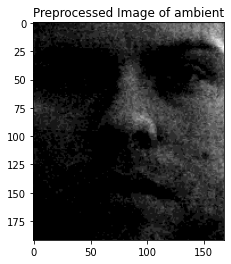

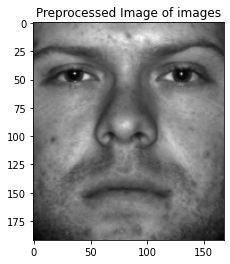

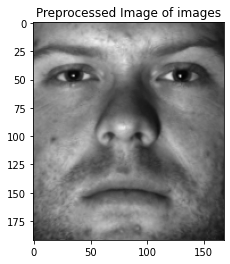

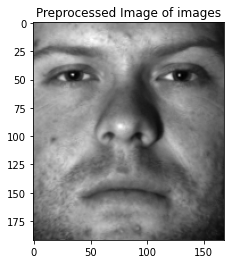

In [4]:
def threshold_image(img):
    ret, thr = cv2.threshold(img, 0, 255, cv2.THRESH_TOZERO_INV)
    new_img = img - thr
    return new_img

def preprocess_data(dataset):
    new_dataset = []
    for i in range(len(dataset)):
        ambient, images, azimuth, elevation = dataset[i]
        new_ambient = threshold_image(ambient)
        new_images = []
        for img in images:
            new_images.append(threshold_image(img))
        new_dataset.append([new_ambient, new_images, azimuth, elevation])
    return new_dataset

dataset = preprocess_data(raw_dataset)

ambient, images, azimuth, elevation = dataset[0]
plt.imshow(ambient, cmap='gray')
plt.title("Preprocessed Image of ambient")
plt.show()
for i in range(3):
    plt.imshow(images[i], cmap='gray')
    plt.title("Preprocessed Image of images")
    plt.show()

Photometric Stereo
1. Determine the light source direction vector(s)

In [5]:
def light_source_vector(azimuth, elevation):
    s_y = np.sin(elevation * np.pi / 180)
    s_xz = np.cos(elevation * np.pi / 180)
    s_x = -np.sin(azimuth * np.pi / 180) * s_xz
    s_z = np.cos(azimuth * np.pi / 180) * s_xz
    s_x = np.reshape(s_x, (1,-1))
    s_y = np.reshape(s_y, (1,-1))
    s_z = np.reshape(s_z, (1,-1))
    light_vector = np.concatenate((s_y, s_x, s_z), axis=0)
    return light_vector.T

light_vectors = light_source_vector(azimuth, elevation)

2. Compute Albedo and Surface Normal

In [6]:
def albedo_surface_norm(images, light_vectors):
    y_size, x_size = images[0].shape
    surface_norm = np.zeros((y_size, x_size, 3))
    albedo = np.zeros((y_size, x_size))
    for y in range(y_size):
        for x in range(x_size):
            E = []
            S = []
            for image, light_vec in zip(images, light_vectors):
                E.append(image[y][x])
                S.append(light_vec)
            E = np.array(E)
            S = np.array(S)
            b = np.dot(np.linalg.pinv(S), E)
            point_albedo, point_surface_norm = np.linalg.norm(b), b / np.linalg.norm(b)
            surface_norm[y][x] = point_surface_norm
            albedo[y][x] = point_albedo
    return surface_norm, albedo

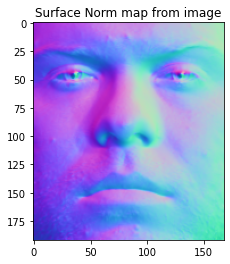

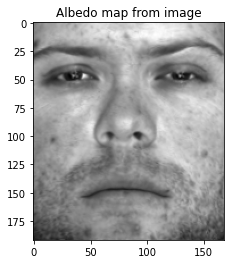

In [7]:
surface_norm, albedo = albedo_surface_norm(images, light_vectors)
plt.imshow((surface_norm + 1) / 2)
plt.title("Surface Norm map from image")
plt.show()
plt.imshow((albedo) / 255, cmap='gray')
plt.title("Albedo map from image")
plt.show()

3. Evaluate result by synthesizing the face images in different light sources directions

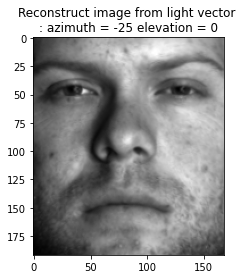

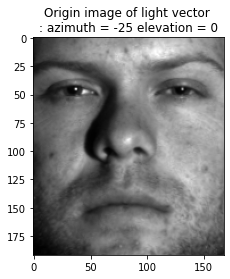

In [8]:
def image_from_light_vector(surface_norm, albedo, light_vector):
    y_size, x_size = albedo.shape
    image = np.zeros((y_size, x_size))
    for y in range(y_size):
        for x in range(x_size):
            image[y][x] = albedo[y][x] * np.dot(surface_norm[y][x], light_vector)
    return image

reconstruct_image = image_from_light_vector(surface_norm, albedo, light_vectors[9])
origin_image = images[9]

plt.imshow(reconstruct_image, cmap='gray')
plt.title(("Reconstruct image from light vector \n: azimuth = "
           + str(azimuth[9]) + " elevation = " + str(elevation[9])))
plt.show()
plt.imshow(origin_image, cmap='gray')
plt.title(("Origin image of light vector \n: azimuth = "
           + str(azimuth[9]) + " elevation = " + str(elevation[9])))
plt.show()

4. Compare the result of using different number of images

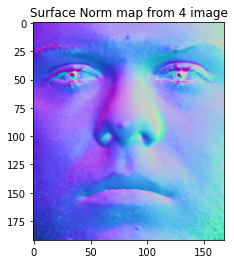

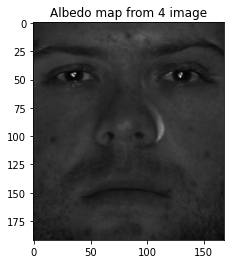

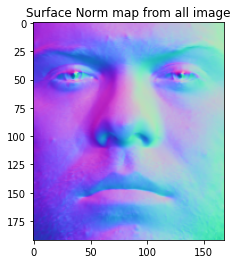

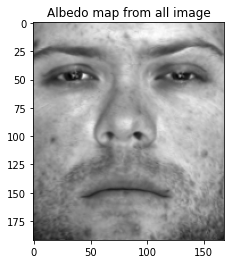

In [9]:
use_4_images = albedo_surface_norm(images[0:3], light_vectors[0:3])
use_all_images = albedo_surface_norm(images, light_vectors)

plt.imshow((use_4_images[0] + 1) / 2)
plt.title("Surface Norm map from 4 image")
plt.show()
plt.imshow((use_4_images[1]) / 255, cmap='gray')
plt.title("Albedo map from 4 image")
plt.show()
plt.imshow((use_all_images[0] + 1) / 2)
plt.title("Surface Norm map from all image")
plt.show()
plt.imshow((use_all_images[1]) / 255, cmap='gray')
plt.title("Albedo map from all image")
plt.show()

5. Reconstruct and Show the surface by using simple gradient integration along the path

In [10]:
def reconstruct_surface(surface_norm):
    y_size, x_size, _ = surface_norm.shape
    Z = np.zeros((y_size, x_size))
    p = np.zeros((y_size, x_size))
    q = np.zeros((y_size, x_size))
    for y in range(y_size):
        for x in range(x_size):
            p[y][x] = -surface_norm[y][x][1] / surface_norm[y][x][2]
            q[y][x] = -surface_norm[y][x][0] / surface_norm[y][x][2]
    for v in range(y_size):
        for u in range(x_size):
            Z[v][u] = -np.sum(q[0:v, 0]) + np.sum(p[v, 0:u])
    return Z

In [11]:
def plot_3d(Z):
    plt.rcParams["figure.figsize"] = [7, 7]
    plt.rcParams["figure.autolayout"] = True

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    y_size, x_size = Z.shape
    y = np.array(range(y_size))
    x = np.array(range(x_size))
    X, Y = np.meshgrid(x, y)

    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='gray', linewidth=0, antialiased=False)
    ax.view_init(75,45)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    fig.colorbar(surf, shrink=1, aspect=8)
    plt.tight_layout()
    plt.show()
    plt.rcParams["figure.figsize"] = [7.50, 3.50]
    return

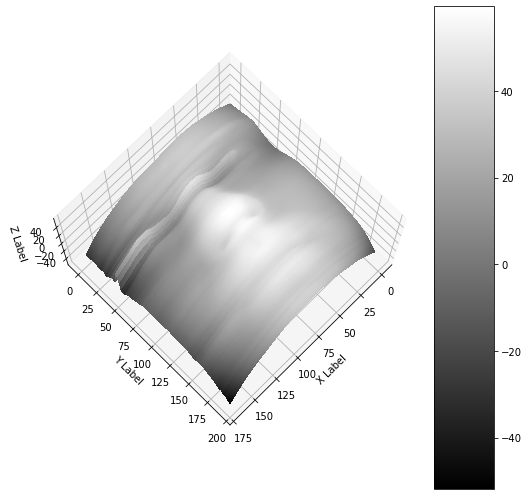

In [12]:
Z1 = reconstruct_surface(surface_norm)

plot_3d(Z1)

6. Use Poisson Solver to Reconstruct surface

In [13]:
def poisson_solver(surface_norm):
    L = []
    y_size, x_size, _ = surface_norm.shape
    p = np.zeros((y_size + 1, x_size + 1))
    q = np.zeros((y_size + 1, x_size + 1))
    U = np.zeros((y_size, x_size))
    L = np.zeros((y_size * x_size, y_size * x_size))
    for y in range(y_size):
        for x in range(x_size):
            p[y + 1][x + 1] = -surface_norm[y][x][1] / surface_norm[y][x][2]
            q[y + 1][x + 1] = -surface_norm[y][x][0] / surface_norm[y][x][2]
            idx = y * x_size + x
            idx_u = (y - 1) * x_size + x
            idx_d = (y + 1) * x_size + x
            idx_l = -1
            idx_r = -1
            if (x != 0):
                idx_l = y * x_size + x - 1
            if (x != x_size - 1):
                idx_r = y * x_size + x + 1
            idx_list = [idx_u, idx_d, idx_l, idx_r]
            L[idx][idx] = -4
            for i in idx_list:
                if i in range(x_size * y_size):
                    L[idx][i] = 1
    for y in range(y_size):
        for x in range(x_size):
            U[y][x] = p[y][x + 1] - p[y][x] - q[y + 1][x] + q[y][x]
    U = np.reshape(U, (-1,1))
    L = sparse.csc_matrix(L)
    LU = sla.splu(L)
    Z = LU.solve(U)
    Z = np.reshape(Z, (y_size, x_size))
    L = []
    return Z

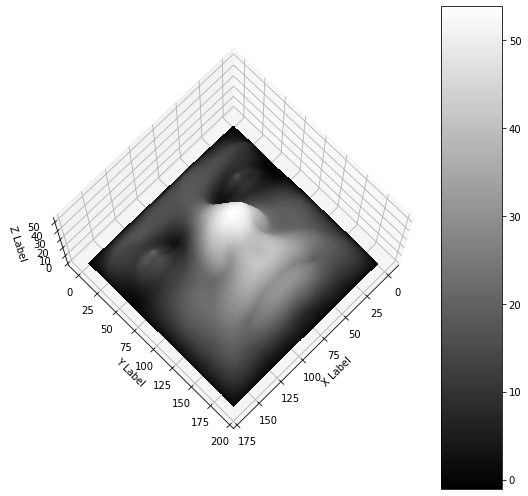

In [14]:
Z2 = poisson_solver(surface_norm)

plot_3d(Z2)